# Save videos with their track trajectories

#### Written by Matan 20230308

In [11]:
import cv2 as cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import matplotlib.animation as animation

def l2n(x):
    return np.array(x)

def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]

def rebin(arr,new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1],
             new_shape[2], arr.shape[2] // new_shape[2])
    
    return arr.reshape(shape).mean(-1).mean(1).mean(2)

def timeToSec(timeStr):#Transform m:s format into total number of seconds
    timeArr = timeStr.split(':')
    timeMin = int(timeArr[0])
    timeSec = int(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec

def animateTrajOnFrame(frm):

    ax.cla()
    
    #Speed up using frameskip
    for i in range(frameSkip):
        ret, img = video.read()
    
    if(ret): #if succesfffuly read an image
        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)

        cond  =  dfS.frame<frameNum            

        dfSC = dfS[cond]

        ax.imshow(img,vmin=0, vmax=255,cmap='gray')
        if len(dfSC)>0 :
            tp.plot_traj(dfSC,ax = ax)#,plot_style={'linewidth':12,'alpha':0.4,'color':'cyan','solid_capstyle':'round'})
    ax.axis('off')

In [12]:
expSumFileName = 'C:\\Users\\User\\Documents\\Eden\\locate_git_code\\two_circles_exp\\two_circles_exp5.csv'
expSum = pd.read_csv(expSumFileName,index_col=0)
expSum=expSum.iloc[[52]]

In [13]:
#speep up and scaling of minified video
scaleDownFactor = 4
speedUpFactor = 1#2#5

#Controlling the output file

#How many frames to skip (speed up and smaller files)
frameSkip = 1#10

#Figure size:
figsize = 3
# Output stream bitrate
bitrate = 1800

In [14]:
smallVideoSuffix = '_small.mp4'
trajVideoSuffix = '_traj_test.mp4'

Plotting trajectory from
	D:\Eden\dress_exp\7_5_24\C0766.MP4_locatedFull20240508_bot_Eden_test.csv_linked.csv
	onto video file:	D:\Eden\dress_exp\7_5_24\C0766.MP4_small.mp4
	Saving to file:	D:\Eden\dress_exp\7_5_24\C0766.MP4_small.mp4_traj_test.mp4
     frame  Unnamed: 0  frame.1      x      y     r  particle
0      407         425      407  490.5  528.5  52.4         0
1      407         426      407  599.5  551.5  51.3         1
2      408         427      408  598.5  551.5  52.4         1
3      408         428      408  490.5  526.5  50.2         0
4      409         429      409  490.5  526.5  52.4         0
..     ...         ...      ...    ...    ...   ...       ...
195    504         620      504  571.5  681.5  50.2         1
196    505         621      505  574.5  577.5  50.2         0
197    505         622      505  569.5  679.5  51.3         1
198    506         623      506  568.5  682.5  51.3         1
199    506         624      506  575.5  580.5  51.3         0

[200 r

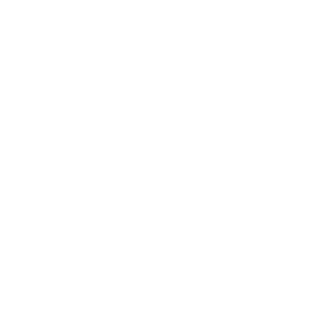

In [15]:
totalTimeStart = time.time()

fig,ax  = plt.subplots(figsize=(figsize,figsize),frameon=False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
for index,row in expSum.iterrows():
    startTime = time.time()
    ############## Fetch experiments data #################
    fileNameVideo ='D:\\Eden\\dress_exp\\7_5_24\\C0766.MP4'+smallVideoSuffix#row['path']+smallVideoSuffix
    fileNameOutput = fileNameVideo + trajVideoSuffix
    fileNameLinked = 'D:\\Eden\\dress_exp\\7_5_24\\C0766.MP4_locatedFull20240508_bot_Eden_test.csv_linked.csv'#row.linkingFileName
    
    print('Plotting trajectory from')
    print('\t'+fileNameLinked)
    print('\tonto video file:\t' + fileNameVideo)
    print('\tSaving to file:\t' + fileNameOutput)


    video = cv2.VideoCapture(fileNameVideo)
    # Load locating file
    df = pd.read_csv(fileNameLinked)
    print(df)
    #Read video paramters
    fps = video.get(cv2.CAP_PROP_FPS)
    totalFrameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #Compute start/end frame of original video
    startMin ='0:00'# row.start_min
    endMin = row.end_min
    startSec = timeToSec(startMin)
    endSec = timeToSec(endMin)
    startFrame = int(startSec*fps)
    endFrame = int(endSec*fps)

    #Shift the data of the linked file to match the minified Video
    dfS = df.copy() #this will be the resacled ans shifted linkin data relative to the minified video
    dfS.frame-=startFrame
    dfS = dfS[dfS.frame>=0]

    dfS.frame/=speedUpFactor
    dfS.x /=scaleDownFactor
    dfS.y /=scaleDownFactor
    
    
    framesToShow = range(0,totalFrameCount,frameSkip)

    Writer = animation.writers['ffmpeg'];
    writer = Writer(fps=fps, metadata=dict(artist='MYBZ'), bitrate=bitrate)

    
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    ani = mpl.animation.FuncAnimation(fig, animateTrajOnFrame,frames=framesToShow);#, frames=datesToPlot, repeat=True)
    ani.save(fileNameOutput, writer=writer)#,savefig_kwargs={'pad_inches':0,'bbox_inches':'tight'});
    #,bbox_inches='tight', transparent="True", pad_inches=0)
    endTime = time.time()
    duration=endTime-startTime
    print('\tplotting trajectory on ' + str(len(framesToShow)) +' frames took + ' +str(duration) + ' seconds.')
    
totalTimeEnd = time.time()
durationTotal = totalTimeEnd-totalTimeStart
print('\nTotal tile for saving trajectories on '+ str(len(expSum)) + ' videos was ' +str(durationTotal/60) + ' minutes')

In [59]:
dfQA = pd.DataFrame({'fileName':[],'ok':[]})
dfQA.fileName = expSum.path+smallVideoSuffix+trajVideoSuffix
dfQA.ok = 0

In [60]:
dfQA.to_csv('QAtable_.csv')

# Archive

In [31]:
print(fileNameOutput)

D:\Matan\20221216\fronters21passive32cm\C0502.MP4_small.mp4_traj.mp4


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(outputFileName,fourcc, fps, (widthScaled,heightScaled))
    
    frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
    ret = True
    print('Start scaling ' +str(endFrame-startFrame) +' frames down of video ' + fileNameVideo + '. Saved to '+ outputFileName)
    while ret and frameNum<endFrame:
        #video.grab()#captureFrame(video,frameNum)
        for i in range(speedUpFactor): #skip frames by speedUpFactor
            ret, img = video.read()

In [ ]:
video.set(cv2.CAP_PROP_POS_FRAMES, startFrame)

In [ ]:
for i in range(40,41):
    row = expSum.iloc[i]#index,row in expSum.iterrows():
    
    startTime = time.time()
   
    ############## Fetch experiments data #################
    fileNameVideo = row.path + smallVideoSuffix
    fileNameLinked = row.linkingFileName
    
    startMin = row.start_min
    endMin = row.end_min
    
    ############## load experiments files #################
    # Load video file
    video = cv2.VideoCapture(fileNameVideo)
    # Load locating file
    df = pd.read_csv(fileNameLinked)
    #Load video Data
    fps = video.get(cv2.CAP_PROP_FPS) 
    
    ########### Filename to save small video #############
    outputFileName = fileNameVideo+trajVideoSuffix
    #Compute start and end frame
    startSec = timeToSec(startMin)
    endSec = timeToSec(endMin)
    startFrame = int(startSec*fps)
    endFrame = int(endSec*fps)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(outputFileName,fourcc, fps, (widthScaled,heightScaled))
    video.set(cv2.CAP_PROP_POS_FRAMES, startFrame)
    frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
    ret = True
    print('Start scaling ' +str(endFrame-startFrame) +' frames down of video ' + fileNameVideo + '. Saved to '+ outputFileName)
    while ret and frameNum<endFrame:
        #video.grab()#captureFrame(video,frameNum)
        for i in range(speedUpFactor): #skip frames by speedUpFactor
            ret, img = video.read()

        if(ret): #if succesfffuly read an image
            frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
            #imgRed = img[:,:,0]

            #For large images, locate a cropped window
            imgCropped = cropImage(img,x0,y0,width,height)
            imgScaled = cv2.resize(imgCropped,(widthScaled,heightScaled),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
            #Edge detection:
            out.write(imgScaled)
            #df = pd.concat([df,dft],ignore_index=True)

    video.release()
    out.release()

    endTime = time.time()
    duration = endTime-startTime
    print('Scaling and cropping '+ fileNameVideo + ' with '+ str(frameNum-startFrame) + ' frames took ' + str(duration) + ' seconds.')
endTimeGlobal = time.time()
durationGlobal = endTimeGlobal-startTimeGlobal

In [31]:
fileNameVideo = row['path']+smallVideoSuffix
fileNameLinked = row.linkingFileName
video = cv2.VideoCapture(fileNameVideo)
df = pd.read_csv(fileNameLinked)



In [ ]:
#loop though all frames
#on each frame
#1. show frame
#2. Draw trajectory up to that frame (with propper time/space scaling)
#3. Add to output video
#save

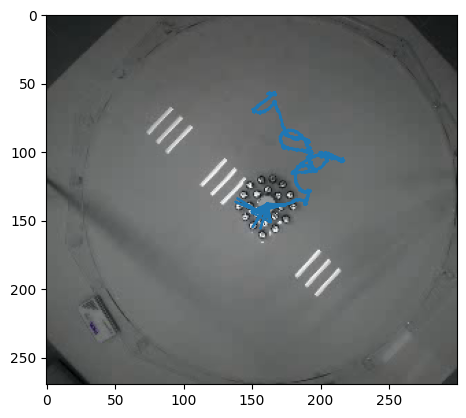

In [32]:
ret, img = video.read()
plt.imshow(img)
x,y = df.x/scaleDownFactor,df.y/scaleDownFactor
plt.plot(x,y)

In [220]:
scaleDownFactor = 4
speedUpFactor = 5

width,height = 1200,1080
x0,y0 = 300,0
widthScaled = width//scaleDownFactor
heightScaled = height//scaleDownFactor

startTimeGlobal = time.time()


for index,row in expSum.iterrows():
    
    startTime = time.time()
   
    ############## Fetch experiments data #################
    fileNameVideo = row.path
    fileNameLinked = row.linkingFileName
    
    startMin = row.start_min
    endMin = row.end_min
    
    ############## load experiments files #################
    # Load video file
    video = cv2.VideoCapture(fileNameVideo)
    # Load locating file
    df = pd.read_csv(fileNameLinked)
    #Load video Data
    fps = video.get(cv2.CAP_PROP_FPS) 
    
    ########### Filename to save small video #############
    outputFileName = fileNameVideo+smallVideoSuffix
    #Compute start and end frame
    startSec = timeToSec(startMin)
    endSec = timeToSec(endMin)
    startFrame = int(startSec*fps)
    endFrame = int(endSec*fps)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(outputFileName,fourcc, fps, (widthScaled,heightScaled))
    video.set(cv2.CAP_PROP_POS_FRAMES, startFrame)
    frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
    ret = True
    print('Start scaling ' +str(endFrame-startFrame) +' frames down of video ' + fileNameVideo + '. Saved to '+ outputFileName)
    while ret and frameNum<endFrame:
        #video.grab()#captureFrame(video,frameNum)
        for i in range(speedUpFactor): #skip frames by speedUpFactor
            ret, img = video.read()

        if(ret): #if succesfffuly read an image
            frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
            #imgRed = img[:,:,0]

            #For large images, locate a cropped window
            imgCropped = cropImage(img,x0,y0,width,height)
            imgScaled = cv2.resize(imgCropped,(widthScaled,heightScaled),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
            #Edge detection:
            out.write(imgScaled)
            #df = pd.concat([df,dft],ignore_index=True)

    video.release()
    out.release()

    endTime = time.time()
    duration = endTime-startTime
    print('Scaling and cropping '+ fileNameVideo + ' with '+ str(frameNum-startFrame) + ' frames took ' + str(duration) + ' seconds.')
endTimeGlobal = time.time()
durationGlobal = endTimeGlobal-startTimeGlobal

print('Scaling and crroping ' + str(len(expSum)) + ' videos took' + str(durationGlobal) + ' seconds')

Start scaling 30150down video D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4. Saved to D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4_small.mp4
Scaling and cropping D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4 with 30150.0 frames took 189.89156126976013 seconds.
Start scaling 30225down video D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4. Saved to D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4_small.mp4
Scaling and cropping D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4 with 30225.0 frames took 194.6029281616211 seconds.
Start scaling 30350down video D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4. Saved to D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4_small.mp4
Scaling and cropping D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4 with 30195.0 frames took 189.33854389190674 seconds.
Start scaling 30150down video D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4. Saved to D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4_small.mp4
Scaling and cropping D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4 with 30150.0 frames took 193.9424076080322

In [216]:
str(len(expSum))

'42'

In [132]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)

widthScaled = width//scaleDownFactor
heightScaled = height//scaleDownFactor

ret, img = video.read()
imgCropped = cropImage(img,x0,y0,width,height)
startTime = time.time()
imgScaledI = cv2.resize(imgCropped,(widthScaled,heightScaled),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
endTime = time.time()
durationTime = endTime-startTime
print(durationTime*1E6)

startTime = time.time()
imgScaledN = rebin(imgCropped,(heightScaled,widthScaled,3)).astype(int)
endTime = time.time()
durationTime = endTime-startTime
print(durationTime*1E6)


732.6602935791016
32708.64486694336


In [208]:
print(outputFileName)

D:\Matan\20221216\fronters21passive32cm\C0500.MP4_small.mp4


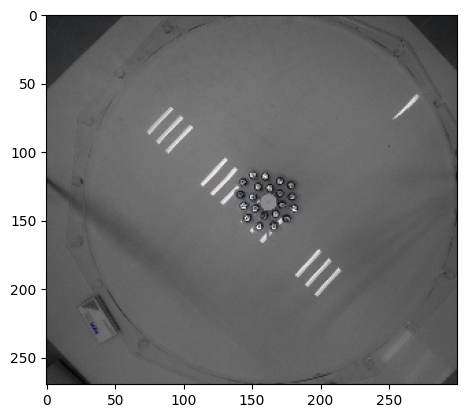

In [104]:
plt.imshow(imgScaled)

In [119]:
10

(1080, 1200, 3)

In [124]:
imgCropped.shape
imgScaled = rebin(imgCropped,(heightScaled,widthScaled,3)).astype(int)

In [122]:
imgCropped.shape

(1080, 1200, 3)

In [123]:
(widthScaled,heightScaled,3)

(300, 270, 3)

In [120]:
3888000/300/3/270/4/3/1


1.3333333333333333

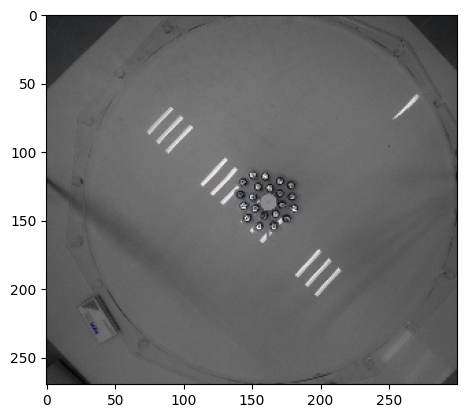

In [115]:
plt.imshow(imgScaled)


In [18]:
imgC.shape[0]

1080

In [ ]:
img  = captureFrame(video,frameNum)
imgCropped =cropImage(img,300,0,1200,int(height))

In [ ]:
ap = cv2.VideoCapture('C:/New folder/video.avi')
 
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 5, (1280,720))
 
while True:
    ret, frame = cap.read()
    if ret == True:
        b = cv2.resize(frame,(1280,720),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        out.write(b)
    else:
        break
    
cap.release()
out.release()
cv2.destroyAllWindows()